Joe figures out that he should use standard stars to remove most of the radial velocity variations due to the Earth's rotation and orbital motion. He modifies his procedures and now produces nice tables of radial velocities which show only the change due to the star's own motion.
The following three questions are based on his observations of new objects -- NOT the same as the star in Question 1.

# 2. 
Over a period of several years, Joe measures the radial velocity of one particular star. He sees pretty clear evidence for an exoplanet.

**Hint: the periods in the questions below should all be in the range of 1 - 20 days. If you are using a tool to find the period, it is a good idea to search using a step size <= 0.01 days**

## a. What is the period of variations in this star's radial velocities?

In [2]:
# url = 'http://spiff.rit.edu/classes/extrasol/homework/hw_4/rv_2.dat'
# req = urllib.request.Request(url)
# with urllib.request.urlopen(req) as response:
#    html = response.read()

# outpath = 'RV_2_{}.dat'.format(time.strftime("%Y%m%d")) #include date of download

# print("retrieving URL: {}".format(url))

# with open(outpath,'wb') as f:
#      f.write(html)
# print("created file: {}".format(outpath))

In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%pylab inline

filename='rv_2.dat'
df = pd.read_csv(filename,delim_whitespace=True)# error_bad_lines=False, skiprows=?
df.tail()

Populating the interactive namespace from numpy and matplotlib


,HJD,RV,error
53,2.455315e+06,-7.31,4.17
54,2.455315e+06,-21.09,4.24
55,2.455315e+06,-28.12,4.36
56,2.455315e+06,-20.81,3.86
57,2.455315e+06,-41.51,4.05


In [4]:
len(df)

58

/home/dl/miniconda2/envs/transit/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


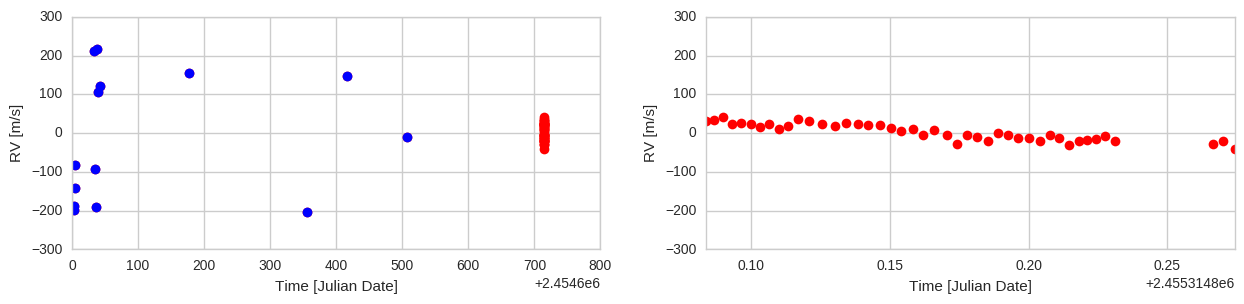

In [5]:
#fig, ax = plt.subplots()
#df.plot(yerr=df.error, ax=ax, kind='scatter')
import seaborn as sb

t=df.HJD 
RV=df.RV
cutoff = 14
with sb.axes_style('whitegrid'):
    fig, ax = plt.subplots(1,2,figsize=(15,3))
    ax[0].plot(t,RV,'ro')
    ax[0].plot(t[:cutoff],RV[:cutoff], 'bo')
    ax[0].set_xlabel('Time [Julian Date]')
    ax[0].set_ylabel('RV [m/s]')
    ax[1].plot(t,RV,'ro');
    ax[1].set_xlim([t[cutoff],t[len(df)-1]]) #take the 
    ax[1].set_xlabel('Time [Julian Date]');
    ax[1].set_ylabel('RV [m/s]');

To compute the period, we need to fit a curve first.

In [6]:
import gatspy
from gatspy.periodic import LombScargleFast

t, f = t, df.RV   
f /= np.median(f)                 #normalize

model = LombScargleFast().fit(t, f)
periods, power = model.periodogram_auto(nyquist_factor=100)

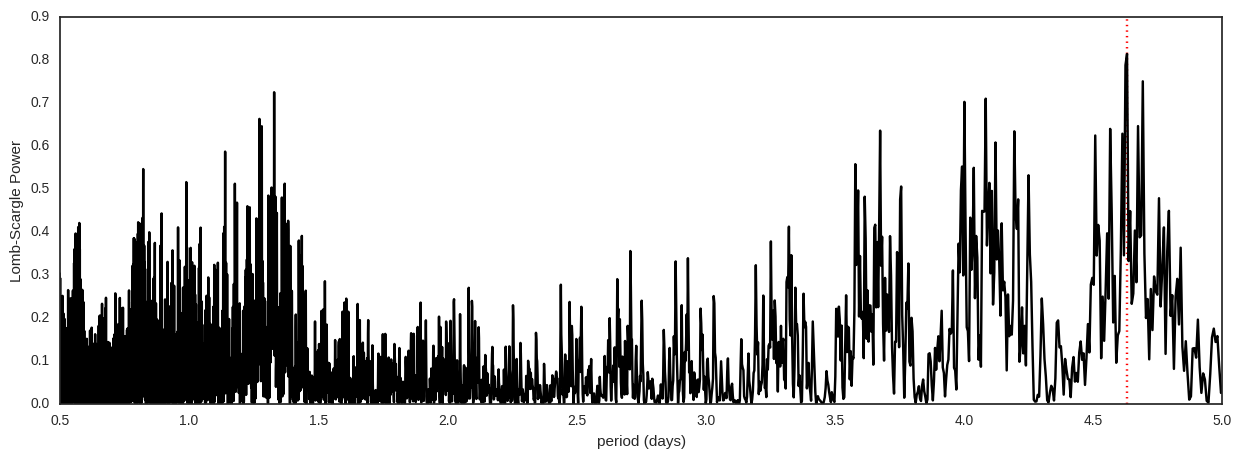

In [7]:
idx1 = periods > 1
idx2 = np.argmax(power[idx1])
peak = periods[idx1][idx2]

with sb.axes_style('white'):
    fig, ax = plt.subplots(1,1,figsize=(15,5))
    ax.plot(periods, power, 'k-')
    ax.set(xlim=(0.5, 5),
       xlabel='period (days)',
       ylabel='Lomb-Scargle Power')
    ax.vlines(peak, *ax.get_ylim(), linestyles='dotted', colors='r')

In [8]:
print("Period is {0:.3} days".format(peak))

Period is 4.63 days


The periodogram shows low frequency noise due to bunch of datapoints towards the end of observation that have less than 1 period. Let's remove these datapoints, leaving only only the first 10, and make another periodogram to check if the same period is dominant.

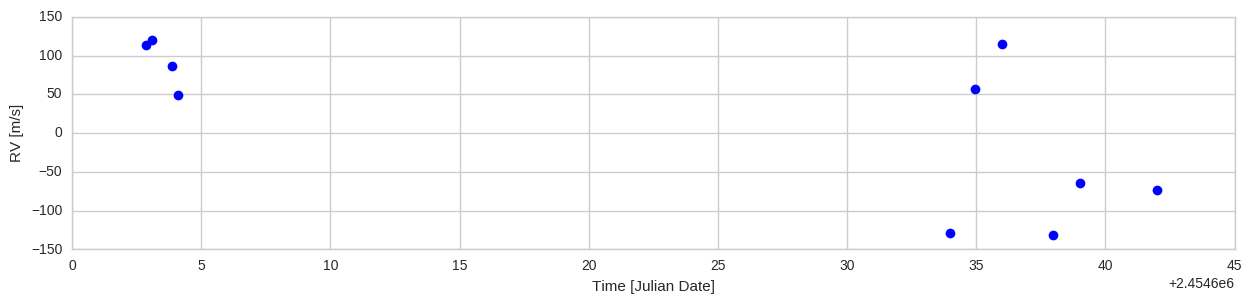

In [9]:
lower_cutoff=10
t1, RV1, err1 = t[:lower_cutoff],RV[:lower_cutoff], df.error[:lower_cutoff]
with sb.axes_style('whitegrid'):
    fig, ax = plt.subplots(1,1,figsize=(15,3))
    ax.plot(t1, RV1,'bo');
    ax.errorbar(t1,RV1,yerr=err1, linestyle="None") #error bars smaller than the datapoints
    ax.set_xlabel('Time [Julian Date]');
    ax.set_ylabel('RV [m/s]');

In [10]:
import gatspy
from gatspy.periodic import LombScargleFast

model = LombScargleFast().fit(t1, RV1)
periods, power = model.periodogram_auto(nyquist_factor=100)

/home/dl/miniconda2/envs/transit/lib/python3.5/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "


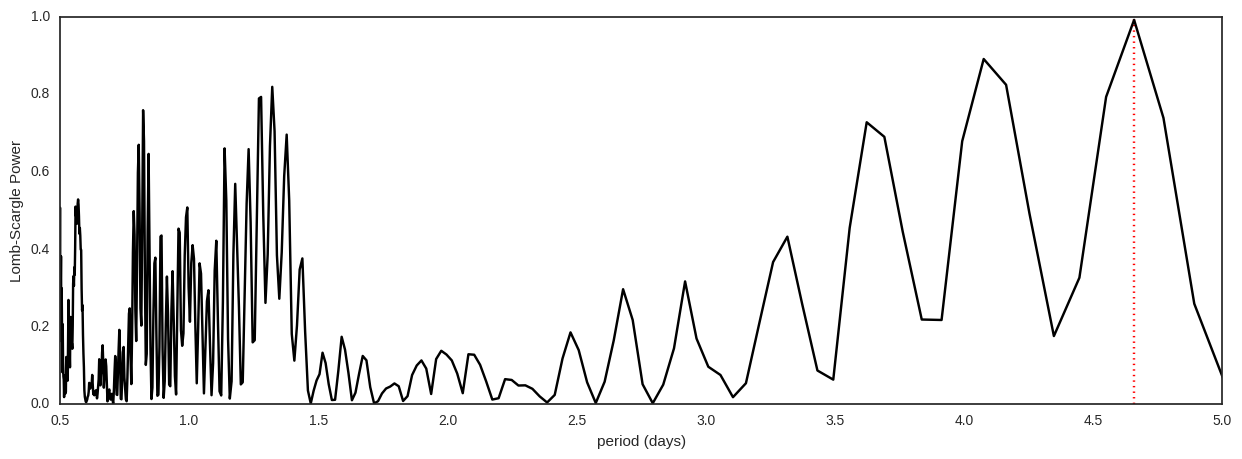

In [11]:
idx1 = periods > 1
idx2 = np.argmax(power[idx1])
peak = periods[idx1][idx2]

with sb.axes_style('white'):
    fig, ax = plt.subplots(1,1,figsize=(15,5))
    ax.plot(periods, power, 'k-')
    ax.set(xlim=(0.5, 5),
       xlabel='period (days)',
       ylabel='Lomb-Scargle Power')
    ax.vlines(peak, *ax.get_ylim(), linestyles='dotted', colors='r')

Indeed, the same dominant period becomes more apparent even with sparse datapoints. Note that low frequency noise is minimized.

In [12]:
print("Period is {0:.3} days".format(peak))

Period is 4.66 days


Then, let's optimize the fitting parameters.

In [13]:
import scipy.optimize as opt
#opt.minimize?

K = max(RV1)+10
def simple_cos(theta, x):
    K, P, phi = theta
    return K*np.cos(2*np.pi*(x-phi)/P)

def objective(theta, xi, yi):
    model = simple_cos(theta, xi)
    return np.sum((model - yi)**2) #res**2

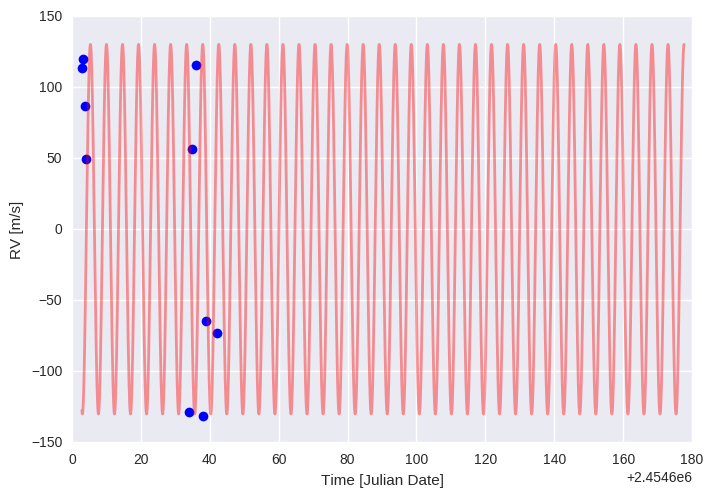

In [14]:
P=peak
init_guess = [K,P,0] #K,P,phi

x = np.arange(t[0],t[lower_cutoff],0.01)
plt.plot(t1,RV1,'bo');
plt.plot(x, simple_cos(init_guess, x),'r-', lw=2, alpha=0.4)
plt.xlabel('Time [Julian Date]');
plt.ylabel('RV [m/s]');

Fit seems a little off in phase.

In [15]:
optimize = opt.minimize(objective, init_guess, args=(t1,RV1), method='nelder-mead')
optimize

 final_simplex: (array([[  1.25135068e+02,   4.79005733e+00,   9.59719186e-05],
       [  1.25135068e+02,   4.79005733e+00,   9.59719187e-05],
       [  1.25135068e+02,   4.79005733e+00,   9.59719187e-05],
       [  1.25135068e+02,   4.79005733e+00,   9.59719184e-05]]), array([ 34391.73527604,  34391.73529954,  34391.73531291,  34391.73533395]))
           fun: 34391.73527603953
       message: 'Optimization terminated successfully.'
          nfev: 194
           nit: 88
        status: 0
       success: True
             x: array([  1.25135068e+02,   4.79005733e+00,   9.59719186e-05])

In [16]:
for i in optimize.x: #x is the result of opt.minimize
    print('Success={}'.format(optimize.success))
    print("parameter optimum: {}".format(i))

Success=True
parameter optimum: 125.13506821182133
Success=True
parameter optimum: 4.790057329612633
Success=True
parameter optimum: 9.597191860272266e-05


Re-plot using optimized values.

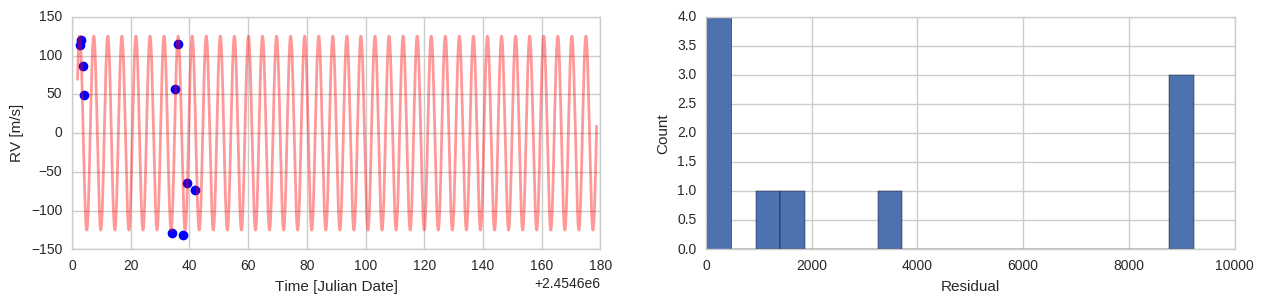

In [17]:
new_guess = []

for i in optimize.x:
    new_guess.append(i)

x = np.arange(t[0]-1,t[lower_cutoff]+1,0.01)

res=[]
for i,j in zip(t1,RV1): 
    res.append(np.sum(simple_cos(new_guess, i)-j)**2)
             
with sb.axes_style('whitegrid'):
    fig, ax = plt.subplots(1,2,figsize=(15,3))
    ax[0].plot(t1,RV1,'bo')
    ax[0].plot(x, simple_cos(new_guess, x),'r-', lw=2, alpha=0.4)
    ax[0].set_xlabel('Time [Julian Date]')
    ax[0].set_ylabel('RV [m/s]')
    ax[1].hist(res,bins=20)
    ax[1].set_xlabel('Residual')
    ax[1].set_ylabel('Count')

To double check, we use a different optimizer.

In [18]:
phi=new_guess[2] #optimize.x[2]
y_noisy= K * np.sin(2*np.pi*(x-phi)/P)

In [19]:
#create a function identical to simple_sine
#mapping/copying of simple_sine to h
h = lambda x,V,P,phi: K * np.cos(2*np.pi*(x-phi)/P)

p_opt, p_cov = opt.curve_fit(h, t1, RV1, p0=new_guess)
var = np.diag(p_cov)
std = np.sqrt(np.diag(p_cov)) #a.k.a. sigma

# for i,j in zip(p_opt, std):
#     print ("parameter optimum: {} +/- {}".format(i, j))

print ("optimum: K={0} m/s; P={1} d; phi={2}".format(p_opt[0],p_opt[1],p_opt[2]))

optimum: K=125.13506821182133 m/s; P=4.790057326459369 d; phi=9.597191860272266e-05


/home/dl/miniconda2/envs/transit/lib/python3.5/site-packages/scipy/optimize/minpack.py:715: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


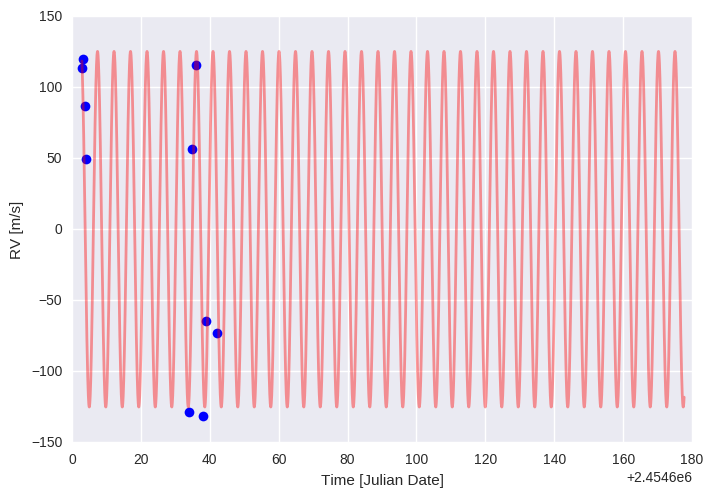

In [20]:
newer_guess = []
for i in p_opt:
    newer_guess.append(i)

x = np.arange(t[0],t[lower_cutoff],0.01)
plt.plot(t1,RV1,'bo');
plt.plot(x, simple_cos(newer_guess, x),'r-', lw=2, alpha=0.4)
plt.xlabel('Time [Julian Date]');
plt.ylabel('RV [m/s]');

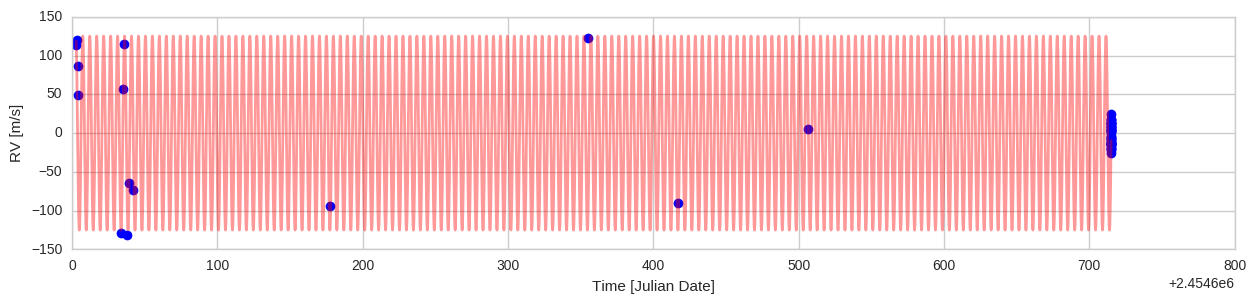

In [21]:
x = np.arange(t[0],t[57],0.01)
with sb.axes_style('whitegrid'):
    fig, ax = plt.subplots(1,1,figsize=(15,3))
    ax.plot(t, RV,'bo')
    ax.plot(x, simple_cos(newer_guess, x),'r-', lw=2, alpha=0.4)
    ax.errorbar(t1,RV1,yerr=err1, linestyle="None") #error bars smaller than the datapoints
    ax.set_xlabel('Time [Julian Date]')
    ax.set_ylabel('RV [m/s]')
# with sb.axes_style('whitegrid'):
#     fig, axs = plt.subplots(1,1,figsize=(15,3))
#     axs.plot(t,RV,'bo');
#     axs.plot(x, simple_cos(newer_guess, x),'r-', lw=2, alpha=0.4)
#     axs.set_xlim([t[cutoff],t[len(df)-1]]) #take the 
#     axs.set_xlabel('Time [Julian Date]');
#     axs.set_ylabel('RV [m/s]');

In [22]:
print("The optimum period is P= {} m/s".format(optimize.x[1]))

The optimum period is P= 4.790057329612633 m/s


In [23]:
print("The difference in the computed periods ({} m/s) using the two optimizers is small.".format(optimize.x[1]-p_opt[1]))

The difference in the computed periods (3.1532643163245666e-09 m/s) using the two optimizers is small.


## b. Assuming that this is a Sun-like star, what is the orbital radius and mass of the planet?

Because the mass of the planet is unknown yet, we can use the semi-amplitude equation to derive/obtain M_planet and then use the Kepler's equation to calculate the planet's orbit. Instead, use semi-amplitude equation to derive M_planet and then use Kepler's third law to compute planet's orbit.

In [24]:
G= 6.67E-11
M_sun= 1.989E30 # in kg
M_Jup = 1.898E27 # in kg
M_Earth = 5.972E24
M_star = M_sun
au = 1.496E11 #in meters

P=optimize.x[1]
v_star=optimize.x[0]

M_0= 0

a = ((G*(M_star+M_0)*(P*60*60*24)**2)/(4*np.pi**2))**(1/3)
print("Semi-major axis= {0:.3} m or {1:.3} AU".format(a, a/au))

v_planet = 2*np.pi*a/P
print("v_planet= {0:.3} m/s".format(v_planet))
M_planet=M_star*abs(v_star)/v_planet

print("M_planet= {0:.3} kg or {1:.3} M_Jup or or {2:.3} M_Earth".format(M_planet, M_planet/M_Jup, M_planet/M_Earth))

Semi-major axis= 8.32e+09 m or 0.0556 AU
v_planet= 1.09e+10 m/s
M_planet= 2.28e+22 kg or 1.2e-05 M_Jup or or 0.00382 M_Earth


## c. Bonus! This is a real exoplanet. Which one?